In [1]:
!pip install mxnet-cu101mkl

### Input layer : 784 nodes, hidden : 256 and output : 10

Initialize with normal weights and biases

In [0]:
import mxnet as mx
from mxnet import gluon

num_inputs = 784
num_outputs = 10
hidden = 256

w1 = mx.random.normal(0, 0.01, (num_inputs, hidden))
w2 = mx.random.normal(0, 0.01, (hidden, num_outputs))
b1 = mx.random.normal(0, 0.01, (hidden))
b2 = mx.random.normal(0, 0.01, (num_outputs))

### Rectified Linear Unit as Activation function

In [0]:
def relu(X):

  return mx.nd.maximum(X, 0)

Net with one hidden layer

In [0]:
def net(X):

  X = X.reshape((-1, num_inputs))
  h = mx.nd.relu(mx.nd.dot(X, w1) + b1)

  return mx.nd.dot(h,w2) + b2

In [0]:
# def loss(y_hat, y):
#     return - mx.nd.log(y_hat[mx.nd.arange(len(y_hat)), y])

### SoftMax cross entropy loss


In [0]:
loss = mx.gluon.loss.SoftmaxCrossEntropyLoss()

In [0]:
params = [w1, b1, w2, b2]

In [0]:
for param in params:
  param.attach_grad()

### Train epoch


In [0]:
def train(net, train_iter, loss, updater ):

  metric = Accumulator(3)


  

  for X,y in train_iter:




    with mx.autograd.record():

      y_hat = net(X)
      l = loss(y_hat, y)

    l.backward()

    updater(X.shape[0], lr, params)

    metric.add([l.sum().astype(float), accuracy(y_hat, y).astype(float), y.size] )
  # print("hi")
  # print(metric.data)

  return metric[0]/metric[2] , metric[1] / metric[2]




In [0]:
class Accumulator():

  def __init__(self, size):

    self.n = size

    self.data = [0] * self.n

  def add(self, data):

    self.data = [x + y for x,y in zip(data, self.data)]

  def __getitem__(self, i):

    if type(self.data[i]) == int:
      return self.data[i]

    return self.data[i].astype(float)[0]

### Plot training progress

In [0]:
from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt

class Animator:

  def __init__(self , x, y, title, labels, range, figsize, xlabel, ylabel ):

    self.x = x
    self.y = y
    self.title = title
    self.labels = labels
    self.xlabel = xlabel
    self.ylabel = ylabel
    self.range = range
    self.figsize = figsize



  def add_to_plot(self, x, y):

    """
    x : list of data points you want to add to x axis dimension : n
    y: list of lists where each list has a dimension n (n is the number of individual line plots)
    """
    # print("Hi")
    self.x = self.x + x
    for i, yi in enumerate(self.y):
      yi[:] = yi + y[i]
    

  

    sns.set_style("darkgrid")

    for i,j in enumerate(self.y):
      print(j)
      plt.legend().remove()
      plt.plot(self.x,j, label = self.labels[i])
    plt.legend()
    plt.title(self.title)
    plt.xlabel(self.xlabel)
    plt.ylabel(self.ylabel)
    plt.show()
    
    
    display.display(plt)
    display.clear_output(wait=True)
    

    
    
    
    



  





In [0]:
num_epochs, lr = 10, 0.5


In [0]:
### Evaluate accuracy 

In [0]:
def eval_accuracy(net, data_iter):

  metric = Accumulator(2)

  for X,y in data_iter:
     metric.add([accuracy(net(X), y), y.size])

  return metric[0] / metric[1]

In [0]:

def accuracy(y_hat, y):
    if y_hat.shape[1] > 1:
        return ((y_hat.argmax(axis=1) == y.astype('float32')).sum()).astype('float32')
    else:
        return ((y_hat.astype('int32') == y.astype('int32')).sum()).astype('float32')

### Stochastic Gradient descent

In [0]:
def sgd(parameters, lr, batch_size):

  """
  Stochastic gradient descent

  parameters: model parameters
  lr : learning rate
  batch_Size : mini batch size
  returns: updated parameters  
  """
  for param in parameters:
    param[:] = param - lr * param.grad / batch_size

### Function to displa images

In [0]:
import matplotlib.pyplot as plt
import sys

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [0]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [0]:
def get_dataloader_workers(num_workers=4):
    # 0 means no additional process is used to speed up the reading of data.
    if sys.platform.startswith('win'):
        return 0
    else:
        return num_workers

In [0]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load into memory."""
    dataset = gluon.data.vision
    trans = [dataset.transforms.Resize(resize)] if resize else [] # resize in terms of pixel

    ### The ToTensor() class normalizes the grayscale values by dividing by 255
    trans.append(dataset.transforms.ToTensor())
    trans = dataset.transforms.Compose(trans )
    mnist_train = dataset.FashionMNIST(train=True).transform_first(trans) # train data
    mnist_test = dataset.FashionMNIST(train=False).transform_first(trans) # test data

    ### return a tuple (train, test) in the batch_size specified
    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle=True,
                                  num_workers=get_dataloader_workers(), ),
            gluon.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                  num_workers=get_dataloader_workers()))

In [0]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

### Train epochs Multi Layer Perceptron

In [0]:
def train_mlp( net, train_iter,test_iter, loss, epochs, updater):

  animator = Animator([],[[],[],[]], "Performance metrics", ["train loss", "train accuracy", "test accuracy"], (3,4), (3,4), "epoch", "value")

  for epoch in range(epochs):

    train_metrics = train(net, train_iter, loss, updater)
    test_acc = eval_accuracy(net, test_iter)
    print(train_metrics[0].asnumpy(), train_metrics[1].asnumpy(), test_acc.asnumpy())
    #animator_trainloss.add_plot(epoch+1, train_metrics[0] )
    #animator_trainaccuracy.add_plot(epoch+1, train_metrics[1])
    y_pt = [list(train_metrics[0].asnumpy()), list(train_metrics[1].asnumpy()), list(test_acc.asnumpy())]
    animator.add_to_plot([epoch+1], y_pt)

### Metrics plotted

No handles with labels found to put in legend.


[0.30346791] [0.88761667] [0.8538]
[0.7807786549250285, 0.4931356721878052, 0.4277384465535482, 0.38835464588801066, 0.36722384128570557, 0.35327456328074136, 0.3357478385925293, 0.32322658739089966, 0.3090243028004964, 0.303467905553182]
[0.7055166666666667, 0.8180166666666666, 0.8428833333333333, 0.8570166666666666, 0.8648, 0.8697333333333334, 0.8763, 0.8804, 0.886, 0.8876166666666667]
[0.7711, 0.8324, 0.8288, 0.8556, 0.8418, 0.86, 0.7978, 0.863, 0.8806, 0.8538]


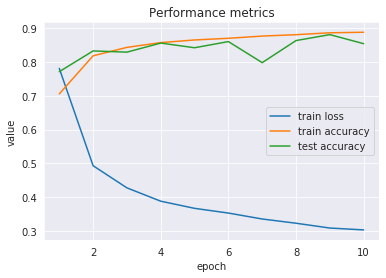

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [23]:
num_epochs, lr = 10, 0.5

def updater(batch_size, lr, params):
    sgd(params, lr, batch_size)

train_mlp(net, train_iter, test_iter, loss, num_epochs, updater)

### Predictions better than softmax linear network

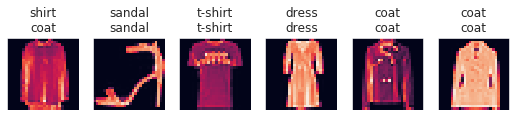

In [25]:
def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y.asnumpy())
    preds = get_fashion_mnist_labels((net(X).argmax(axis=1).asnumpy()))
    titles = [true+'\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[n+1:n+10].reshape(n, 28, 28), 1, n, titles=titles[n+1:n+10])

predict_ch3(net, test_iter)